In [ ]:
from fastai.vision.all import *
from pathlib import Path


import os
kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [ ]:
import h5py
#import requests

f1 = h5py.File('/kaggle/input/generated-jet-images/jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5', 'r')
print(list(f1.keys()))

# Didn't work
#link = "https://data.mendeley.com/public-files/datasets/4r4v785rgx/files/132306f6-26f4-4583-8f1b-ccc5ad8da05d/file_downloaded"
#request = requests.get(link)
#print(list(request.keys()))

In [ ]:
#import numpy
#maxvala = numpy.amax(f1['image'])
#print(maxvala)
### Value is 284.67654

In [ ]:
from PIL import Image
from matplotlib import cm
im = Image.fromarray(f1['image'][0])

In [72]:
import time, torch, os, h5py
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
from matplotlib import cm
import torch



class hdf5_dataset(Dataset):
    def __init__(self, path,limitSize=None, transform=None):
        self.file_path = path
        self.data = None
        self.label = None
        self.maxSize = limitSize
        classes = ["general", "W-boson"]
        self.classes = classes
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        
        if limitSize is None:
            with h5py.File(self.file_path, 'r') as file:
                self.len = len(file['image'])
        else:
            self.len = limitSize
        self.transform = transform

    def __len__(self):
        return self.len
    
    def covertFromNdarrayToTensorRGB(self, ndarray):
        t = torch.from_numpy(ndarray)
        t_stacked = torch.stack([t,t,t], 0)
        #size = t_stacked.shape
        #print("shape: ", size)
        return t_stacked
        
    def __getitem__(self, idx):
        if self.data is None:
            _data = h5py.File(self.file_path, 'r')['image']
            self.data = _data
        if self.label is None:
            self.label = h5py.File(self.file_path, 'r')['signal']

        #self.data_list = list(self.data.keys())
        #self.label_list = list(self.label.keys())
        
        image = self.covertFromNdarrayToTensorRGB(self.data[idx])
        label = int(self.label[idx]) 
        return image, label

In [73]:
datasetSize = 100000
path = '/kaggle/input/generated-jet-images/jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5'
trainset = hdf5_dataset(path, datasetSize, 'train')

In [74]:
i, s = trainset.__getitem__(200)
print(trainset.__getitem__(200))
print(type(i))

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 1)
<class 'torch.Tensor'>


In [75]:
trainset.class_to_idx, trainset.classes, 

({'general': 0, 'W-boson': 1}, ['general', 'W-boson'])

In [76]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

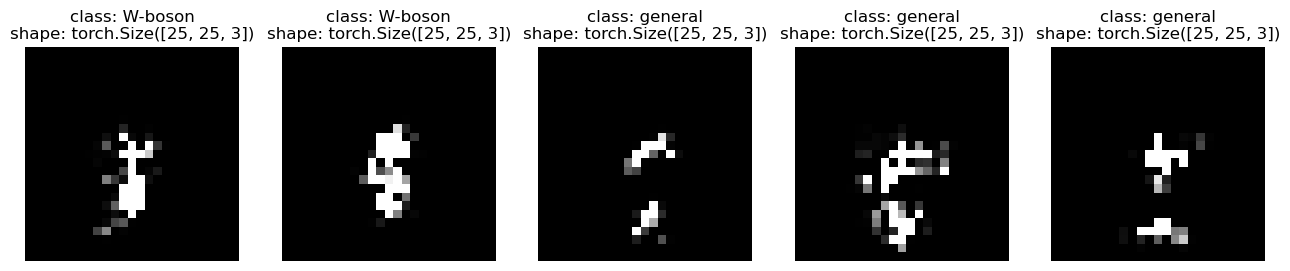

In [57]:
display_random_images(trainset, 
                      n=5, 
                      classes=trainset.classes,
                      seed=None)

In [77]:
from torch.utils.data import random_split

batch_size = 800

print(len(trainset), " batch size: ",batch_size) 
train_set_size = int(len(trainset) * 0.8)
valid_set_size = len(trainset) - train_set_size
#train_set, valid_set = random_split(trainset, [train_set_size, valid_set_size])

if datasetSize is None:
    train_set, valid_set = random_split(trainset, [train_set_size, valid_set_size])
else:
    t = int(datasetSize* 0.8)
    v=datasetSize-t
    train_set, valid_set = random_split(trainset, [t, v])


dl = DataLoader(train_set, batch_size=batch_size, num_workers=0)
dl_val = DataLoader(valid_set, batch_size=batch_size, num_workers=0)

from fastai.vision.data import DataLoaders
data = DataLoaders(dl, dl_val)
dl, dl_val

100000  batch size:  800


(<fastai.data.load.DataLoader at 0x7fe5bc8d6890>,
 <fastai.data.load.DataLoader at 0x7fe5a01197d0>)

In [78]:
img_custom, label_custom = next(iter(dl))
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([800, 3, 25, 25]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([800])


In [ ]:
print(len(dl.dataset))
print(len(dl_val.dataset))

In [79]:
learner_original = vision_learner(data,arch="resnet18", n_in=3, n_out=2,pretrained=False,  loss_func=nn.CrossEntropyLoss(),  metrics=accuracy,normalize=False)

In [80]:
learner_original.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.725543,20.271410,0.562350,07:57
1,0.544267,0.479747,0.775750,07:49
2,0.481374,0.998424,0.596550,07:41
3,0.454667,0.732398,0.654350,07:27
4,0.438617,0.436404,0.799700,07:31


In [81]:
learner_original.show_results(max_n=6)

AttributeError: 'Subset' object has no attribute 'show_results'

In [ ]:
print(torch.cuda.is_available())
torch.cuda.set_device(0)
learner_original.model.cuda()

learner_original.freeze()
learner_original.fit_one_cycle(5)

learner_original.unfreeze()
learner_original.fit_one_cycle(5)